In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



In [2]:
df = pd.read_csv('cleaned_data.csv')
df

,stars,cleaned_text,sentiment
0,1,"['lately', 'common', 'wait', 'hour', 'food', '...",negative
1,5,"['love', 'great', 'offer', 'good', 'selection'...",positive
2,1,"['disappointed', 'app', 'used', 'long', 'time'...",negative
3,2,"['fairly', 'easy', 'use', 'trying', 'find', 'h...",negative
4,4,"['like', 'fact', 'u', 'ca', 'get', 'refund', '...",positive
...,...,...,...
8892,5,"['food', 'good', 'delivery', 'took', 'forever'...",positive
8893,1,"['whenever', 'never', 'sent', 'correct', 'item...",negative
8894,1,"['delivery', 'driver', 'turn', 'incorrect', 'l...",negative
8895,5,"['great', 'deal', 'buddy', 'pizza', 'buy', 'on...",positive


In [3]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_text'])

In [4]:
# Keywords dictionary
keywords_dict = {
    'food quality': ['taste', 'freshness', 'temperature', 'quality'],
    'delivery experience': ['on-time', 'professional', 'courteous', 'careful'],
    'price': ['value', 'reasonable', 'affordable', 'expensive'],
    'customer service': ['helpful', 'responsive', 'knowledgeable', 'friendly'],
    'app functionality': ['easy to use', 'intuitive', 'reliable', 'glitchy']
}

## Clustering Using KMeans

In [11]:
# Initialize and fit K-means clustering model
num_clusters = len(keywords_dict)  # Number of clusters based on the number of keyword categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [6]:
# Get cluster assignments and silhouette score
df['cluster'] = kmeans.labels_
silhouette_avg = silhouette_score(X, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X.toarray(), kmeans.labels_)

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


Silhouette Score: 0.004066134283171353
Davies-Bouldin Index: 10.072790915728147


In [7]:
# Analyze the clusters
cluster_results = df.groupby('cluster')['stars'].mean().reset_index()
print("Cluster Analysis:")
print(cluster_results)

# Determine the best and worst performing categories based on the number of stars
best_category = cluster_results.loc[cluster_results['stars'].idxmax(), 'cluster']
worst_category = cluster_results.loc[cluster_results['stars'].idxmin(), 'cluster']

print(f"\nBest Performing Category: {best_category+1}")
print(f"Worst Performing Category: {worst_category+1}")

Cluster Analysis:
   cluster     stars
0        0  2.456882
1        1  1.518325
2        2  1.273927
3        3  4.801653
4        4  1.160714

Best Performing Category: 4
Worst Performing Category: 5


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Perform keyword analysis
num_top_keywords = 10
for i, cluster_center in enumerate(kmeans.cluster_centers_):
    # Get the indices of the top keywords for the current cluster
    top_keywords_idx = cluster_center.argsort()[-num_top_keywords:][::-1]
    # Get the actual top keywords using the indices
    top_keywords = [vectorizer.get_feature_names_out()[idx] for idx in top_keywords_idx]
    print(f"Cluster {i+1} Top Keywords: {top_keywords}")


Cluster 1 Top Keywords: ['app', 'delivery', 'time', 'fee', 'get', 'restaurant', 'use', 'food', 'service', 'one']
Cluster 2 Top Keywords: ['food', 'driver', 'delivery', 'time', 'cold', 'delivered', 'never', 'hour', 'refund', 'get']
Cluster 3 Top Keywords: ['customer', 'service', 'refund', 'item', 'missing', 'money', 'get', 'support', 'never', 'app']
Cluster 4 Top Keywords: ['great', 'easy', 'fast', 'food', 'delivery', 'hot', 'good', 'service', 'time', 'quick']
Cluster 5 Top Keywords: ['value', 'quality', 'le', 'shipping', 'show', 'return', 'service', 'product', 'food', 'used']


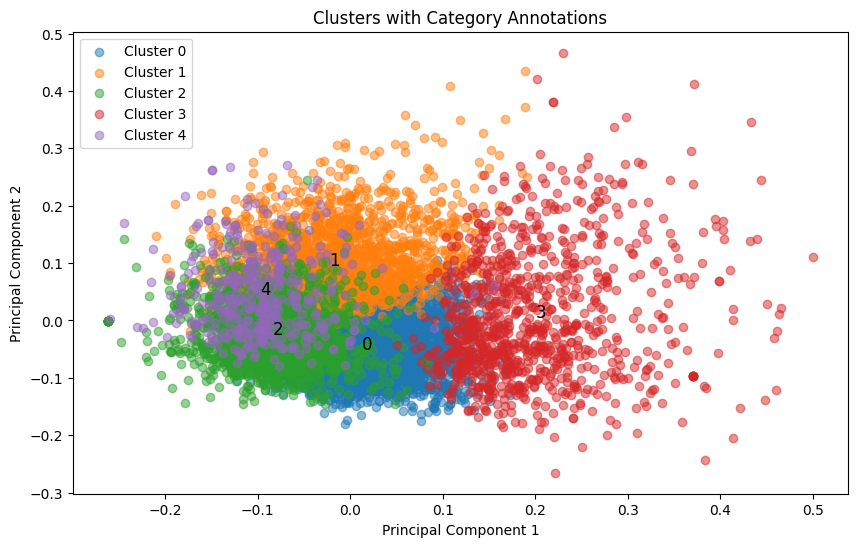

In [9]:
# Fit PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    plt.scatter(X_pca[df['cluster'] == i, 0], X_pca[df['cluster'] == i, 1], label=f'Cluster {i}', alpha=0.5)

# Annotate cluster centers with category
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(cluster_centers_pca):
    plt.text(x, y, f'{i}', fontsize=12, color='black')

plt.title('Clusters with Category Annotations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## DBSCAN

In [15]:
from sklearn.cluster import DBSCAN

# Initialize and fit DBSCAN clustering model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

# Get the cluster labels
cluster_labels = dbscan.labels_

In [21]:
from sklearn.metrics import silhouette_score

# Get cluster assignments and silhouette score for DBSCAN
silhouette_avg = silhouette_score(X, dbscan.labels_)

# Print the silhouette score
print(f"Silhouette Score (DBSCAN): {silhouette_avg}")

Silhouette Score (DBSCAN): -0.028827328115730057


In [25]:
# Assign Cluster Labels
df['cluster'] = dbscan.labels_

# Analyze Cluster Characteristics
cluster_results = df.groupby('cluster')['stars'].mean()

# Print results
print("Cluster Analysis:")
print(cluster_results)

Cluster Analysis:
cluster
-1    2.19067
 0    1.00000
 1    1.00000
 2    5.00000
 3    5.00000
Name: stars, dtype: float64


In [26]:
# 3. Identify Best and Worst Performing Categories
best_category = cluster_results.idxmax()
worst_category = cluster_results.idxmin()

In [27]:
print("\nBest Performing Category:", best_category)
print("Worst Performing Category:", worst_category)


Best Performing Category: 2
Worst Performing Category: 0


In [45]:
cluster_keywords = {}
num_top_keywords = 10  # Adjust to extract top 10 keywords

for cluster_label in df['cluster'].unique():
    cluster_points = X[df['cluster'] == cluster_label]
    cluster_center = cluster_points.mean(axis=0)
    top_keywords_idx = cluster_center.argsort()[0, -num_top_keywords:][::-1]  # Extract top 10 keywords
    top_keywords = [vectorizer.get_feature_names_out()[idx] for idx in top_keywords_idx]
    top_keywords = [str(keyword) for keyword in top_keywords]  # Convert keywords to strings
    cluster_keywords[cluster_label] = top_keywords

# Clean up formatting of the output dictionary
cleaned_cluster_keywords = {}
for cluster_label, keywords in cluster_keywords.items():
    cleaned_cluster_keywords[cluster_label] = ", ".join(keywords)

for cluster in cluster_keywords:
    print(f"Cluster {cluster} Keywords: {cleaned_cluster_keywords[cluster]}")

Cluster -1 Keywords: [['use' 'refund' 'get' 'customer' 'app' 'time' 'driver' 'delivery'
  'service' 'food']]
Cluster 0 Keywords: [['store' 'funny' 'like' 'prepare' 'loose' 'haha' 'even' 'tell' 'oh'
  'said']]
Cluster 1 Keywords: [['money' 'still' 'ca' 'nothing' 'took' 'person' 'end' 'talk' 'real'
  'subway']]
Cluster 2 Keywords: [['feesphenomenal' 'fei' 'feighned' 'feign' 'feigned' 'felicia'
  'feesince' 'über' 'service' 'good']]
Cluster 3 Keywords: [['feesphenomenal' 'fei' 'feighned' 'feign' 'feigned' 'felicia'
  'feesince' 'driver' 'service' 'great']]


- The silhouette score for DBSCAN is negative, indicating that most points are considered as noise by the algorithm.
- The cluster analysis shows that the majority of the data points are assigned to the outlier cluster (-1), indicating that the algorithm failed to form meaningful clusters.
- The keywords extracted from each cluster also seem to be irrelevant and do not provide useful insights into the underlying structure of the data.